In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
output_path = '/home/FRACTAL/shaheen.perveen/stage3/model_outputs/'

In [3]:
import os
os.chdir('/home/FRACTAL/shaheen.perveen/fastai/old')
# This file contains all the main external libs we'll use
from fastai.imports import *

In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from pathlib import *
import pandas as pd
import numpy as np

In [5]:
#checking wheteher cuda and cudnn are available. Cuda is necessary & Cudnn is optional, it makes computation faster
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
#using  device 0-gpu
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [8]:
#checking the data
input_path = '/home/FRACTAL/shaheen.perveen/stage3/fakers/stage-3/stage3_image_data/train/'
# classes = pd.read_csv(input_path+'train_label.csv',header=None)
# classes.rename(columns={0:'label_id',2:'class',1:'to_drop'},inplace=True)
# classes.drop('to_drop',inplace=True,axis=1)

# labels = pd.read_csv(input_path+'scene_labels.csv')
# labels.drop('Unnamed: 0',inplace=True,axis=1)

# labels['label_id'] = labels['label_id'].astype(str)
# classes['label_id']= classes['label_id'].astype(str)

# labels = labels.merge(classes,how='left')
# labels = labels[~labels['class'].isna()]
# labels.reset_index(drop=True,inplace=True)

# labels_model = labels[['image_id','class']]
labels_model = pd.read_csv(input_path+'train_label.csv')

In [9]:
labels_model.head()

,image_id,class
0,/home/FRACTAL/shaheen.perveen/stage3/fakers/st...,real
1,/home/FRACTAL/shaheen.perveen/stage3/fakers/st...,real
2,/home/FRACTAL/shaheen.perveen/stage3/fakers/st...,real
3,/home/FRACTAL/shaheen.perveen/stage3/fakers/st...,real
4,/home/FRACTAL/shaheen.perveen/stage3/fakers/st...,real


In [10]:
labels_model.shape

(32260, 2)

In [11]:
labels_model['image_id'][0]

'/home/FRACTAL/shaheen.perveen/stage3/fakers/stage-3/stage3_image_data/train/real/new_real20190208090259_b94639e64f3efbfb92af036355aed6fc.jpg'

In [10]:
labels = labels_model[['class']]
labels.head()

,class
0,real
1,real
2,real
3,real
4,real


In [11]:
labels['class'] = np.where(labels['class'] == 'real',1,0)
labels.head()

/home/FRACTAL/shaheen.perveen/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,class
0,1
1,1
2,1
3,1
4,1


In [12]:
labels.describe()

,class
count,32260.000000
mean,0.259547
std,0.438393
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [13]:
def get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,label_csv,test_folder,skip_header,augmentation_required):
    if (augmentation_required):
        tfms = tfms_from_model(f_model, sz,aug_tfms=aug_tfms,max_zoom=1.1)
    else:
        tfms =  tfms_from_model(f_model, sz)
    
    label_csv.to_csv(str(root_path)+'temp_label_file.csv',index=False)
    
    return ImageClassifierData.from_csv(root_path, train_folder,str(root_path)+'temp_label_file.csv',bs=bs,tfms=tfms,
                     val_idxs=val_idxs,test_name=test_folder,skip_header=skip_header)

In [14]:
def exp_name(output_path,freeze,model_name,lrn,sz):
    return output_path+freeze+'_'+'_'+model_name+'_lr'+str(lrn)+'_sz'+str(sz)

In [15]:
label_csv = labels_model.copy()
#a root path of the data (used for storing trained models, precomputed values, etc)
root_path=('/home/FRACTAL/shaheen.perveen/stage3/temp_model_parameters/')
#a name of the folder in which training images are contained.
train_folder = ('')
#a name of the folder which contains test images.
test_folder= ('/home/FRACTAL/shaheen.perveen/stage3/fakers/stage-3/stage3_image_data/test/test')

In [16]:
#for generating the validation indexes
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1729)
labels_splits = labels.copy()
X= labels['class'].astype(int)
y=labels['class'].astype(int)

for train_index, test_index in sss.split(X, y):
    trn_indx = train_index
    val_idxs = test_index

In [17]:
f_model=resnext101_64
sz=224
aug_tfms=transforms_side_on
max_zoom=1.1
bs=4
#use this if we dont need augmentation
augmentation_required = True

model_name=str(f_model).split(' ')[1]

In [18]:
#making data object
data = get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,label_csv,test_folder,skip_header=True,augmentation_required=augmentation_required)

In [19]:
learn = ConvLearner.pretrained(f_model, data,precompute=False)

In [60]:
learn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): Sequential(
      (0): LambdaMap(
        (0): Sequential(
          (0): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
            (2): ReLU()
            (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
            (5): ReLU()
          )
          (1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        )
        (1): Sequential(
          (0): Conv2d(64, 256, kernel

In [28]:
child = learn.children

In [29]:
len(child)

18

In [44]:
child[10:]

[BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True),
 Dropout(p=0.25),
 Linear(in_features=4096, out_features=512, bias=True),
 ReLU(),
 BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True),
 Dropout(p=0.5),
 Linear(in_features=512, out_features=2, bias=True),
 LogSoftmax()]

In [65]:
child

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
 ReLU(),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False),
 Sequential(
   (0): Sequential(
     (0): LambdaMap(
       (0): Sequential(
         (0): Sequential(
           (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
           (2): ReLU()
           (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
           (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
           (5): ReLU()
         )
         (1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
       )
       (1): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (1):

In [64]:
child[1]

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)

In [61]:
k=(learn.get_layer_groups())

In [62]:
k[0]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
 ReLU(),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False),
 Sequential(
   (0): Sequential(
     (0): LambdaMap(
       (0): Sequential(
         (0): Sequential(
           (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
           (2): ReLU()
           (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
           (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
           (5): ReLU()
         )
         (1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
       )
       (1): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (1):

In [ ]:
learn.

 64%|██████▎   | 4107/6452 [04:28<02:23, 16.29it/s, loss=2.02] 

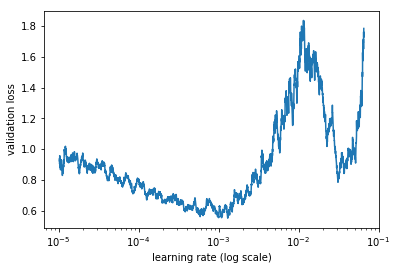

In [30]:
lrf=learn.lr_find()

learn.sched.plot()

In [20]:
lrn=3e-4

In [21]:
lrn

0.0003

In [33]:
learn.fit(lrn, 3, cycle_len=1, cycle_mult=2)


epoch      trn_loss   val_loss   accuracy                      
    0      0.525677   0.524802   0.75031   
    1      0.497268   0.525777   0.747675                      
    2      0.527083   0.515674   0.75031                       
    3      0.560169   0.523115   0.749225                      
    4      0.53416    0.515753   0.752015                       
    5      0.487278   0.511247   0.752635                      
    6      0.568715   0.509495   0.7531                        


[array([0.5095]), 0.7530998140111593]

In [34]:
learn.save(exp_name(output_path,'frz',model_name,lrn,sz))

In [35]:
#loading the previous saved model and unfreezing the network for more training
learn.load(exp_name(output_path,'frz',model_name,lrn,sz))
learn.unfreeze()
learn.bn_freeze(True)

lr=np.array([lrn/100,lrn/10,lrn])

learn.fit(lr, 2, cycle_len=1,cycle_mult=2)
learn.save(exp_name(output_path,'unfrz',model_name,lrn,sz))


epoch      trn_loss   val_loss   accuracy                      
    0      0.493639   0.482662   0.769064  
    1      0.444389   0.46242    0.784408                      
    2      0.423581   0.457818   0.784873                      


In [ ]:
#
learn.load(exp_name(output_path,'unfrz',model_name,lrn,sz))
learn.freeze()

sz=400
#making data object
data = get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,label_csv,test_folder,skip_header=True,augmentation_required=augmentation_required)
learn.set_data(data)



lrn=3e-4

learn.fit(lrn, 3, cycle_len=1, cycle_mult=2)

learn.save(exp_name(output_path,'frz',model_name,lrn,sz))

#loading the previous saved model and unfreezing the network for more training
learn.load(exp_name(output_path,'frz',model_name,lrn,sz))
learn.unfreeze()
learn.bn_freeze(True)

lr=np.array([lrn/100,lrn/10,lrn])

learn.fit(lr, 2, cycle_len=1,cycle_mult=2)
learn.save(exp_name(output_path,'unfrz',model_name,lrn,sz))


epoch      trn_loss   val_loss   accuracy                        
    0      0.456141   0.449638   0.792002  
    1      0.465276   0.443724   0.793552                        
 92%|█████████▏| 5947/6452 [18:16<02:39,  3.16it/s, loss=0.448]  

In [ ]:
#
sz=400
learn.load(exp_name(output_path,'unfrz',model_name,lrn,sz))
learn.freeze()

sz=600
#making data object
data = get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,label_csv,test_folder,skip_header=True,augmentation_required=augmentation_required)
learn.set_data(data)



lrn=3e-4

learn.fit(lrn, 3, cycle_len=1, cycle_mult=2)

learn.save(exp_name(output_path,'frz',model_name,lrn,sz))

#loading the previous saved model and unfreezing the network for more training
learn.load(exp_name(output_path,'frz',model_name,lrn,sz))
learn.unfreeze()
learn.bn_freeze(True)

lr=np.array([lrn/100,lrn/10,lrn])

learn.fit(lr, 2, cycle_len=1,cycle_mult=2)
learn.save(exp_name(output_path,'unfrz_increase_size_from_224',model_name,lrn,sz))

In [44]:
# #loading the previous saved model and unfreezing the network for more training
# learn.load(exp_name(output_path,'frz',model_name,lrn,sz))
# learn.unfreeze()
# learn.bn_freeze(True)

# lr=np.array([lrn/100,lrn/10,lrn])

# learn.fit(lr, 2, cycle_len=1,cycle_mult=2)
# learn.save(exp_name(output_path,'unfrz_increase_size_from_224',model_name,lrn,sz))

epoch      trn_loss   val_loss   accuracy                       
    0      0.426765   0.422728   0.817111  
    1      0.469104   0.421563   0.804867                        
    2      0.432235   0.416165   0.816336                        
    3      0.413201   0.433928   0.801922                        
    4      0.497313   0.419152   0.812771                        
    5      0.522052   0.414157   0.812926                        
    6      0.38752    0.412878   0.814631                        


  0%|          | 0/6452 [00:00<?, ?it/s]

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [22]:
sz=600
learn.load(exp_name(output_path,'frz',model_name,lrn,sz))
learn.freeze()

sz=512
#making data object
data = get_data(f_model,sz,bs,val_idxs,aug_tfms,root_path,train_folder,label_csv,test_folder,skip_header=True,augmentation_required=augmentation_required)
learn.set_data(data)


learn.unfreeze()
learn.bn_freeze(True)

lr=np.array([lrn/100,lrn/10,lrn])

learn.fit(lr, 2, cycle_len=1,cycle_mult=2)
learn.save(exp_name(output_path,'unfrz_increase_size_from_224',model_name,lrn,sz))

epoch      trn_loss   val_loss   accuracy                        
    0      0.374562   0.389659   0.823931  
    1      0.363885   0.386561   0.823621                        
    2      0.248631   0.374155   0.833695                        



In [23]:
fbeta()

<function fastai.metrics.fbeta(log_preds, targs, beta, thresh=0.5, epsilon=1e-08)>